In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np 
from scipy.integrate import quad
from math import *
from astropy.io import fits
import glob
import pylab 
from numpy.linalg import inv
# from iminuit import Minuit, describe, Struct
import pandas

In [15]:
# Physical constantes
clight = 299792.458
# Riess et al. 2016: H0 = 73.24 ± 1.74 km s−1 Mpc−1
H0 = 0.00007324

# Initial values of fitted parameters withb Pantheon results
Npar = 1
omgM = 0.298
# M_b0 = -19.16
# alpha0 = 0.154
# beta0 = 3.030
# gamma0 = 0.053

In [20]:
# Comoving radial coordinate (c not included) corresponding to redshift z = c int_0^z dz/H(z)
# in LambdaCDM flat model
def intfun(z, omgM):
    return 1/sqrt(omgM*(1 + z)**3 + (1 - omgM))

# Luminosity Distance function
def fitfundL(zcmb, omgM, H0):
    mu = []
    for i in range (len(zcmb)): 
        zz = zcmb[i]
        mu.append(dL_z(zz, zz, omgM, H0)) 
    return mu 

# Luminosity Distance corresponding to a redshift z
def dL_z(zcmb, zhel, omgM, H0):
    mu_zz = 5*log10((1 + zhel)*clight*(quad(intfun, 0, zcmb, args=(omgM))[0] / (10*H0)))
    return mu_zz

In [5]:
# Read covariance matrix 
# filecov = 'sys_full_long_G10.txt'
# filecov = 'cov.txt'
filecov = '../data/sys_full_long.txt'

filecov = np.loadtxt('../data/sys_full_long.txt', skiprows=1)
Csys = np.reshape(filecov, (1048, 1048))
# Cinv = Csys
# print('Cinv \n', Csys)

In [62]:
mbErr = []
with open('../data/lcparam_full_long.txt') as catalog:
    for line in catalog:
        column = line.split()
        if not line.startswith('#'): #skipping column labels
            x = (column[5])
            mbErr.append(x)
#print(mbErr)
              
sigma_mb = []
for item in mbErr:
    sigma_mb.append(float(item))
#print(sigma_mb)
    
sigma2_mb = np.square(sigma_mb)
#print(sigma2_mb)

mat_sigma2_mb = np.zeros((1048, 1048), float)
np.fill_diagonal(mat_sigma2_mb, sigma2_mb)
#print(mat_sigma2_mb)

Cmat1 = np.add(Csys,mat_sigma2_mb)
Cmat = np.add(Csys,Cmat1)
Cinv=Cmat

In [63]:
# Definition of chi2 fucntion for minimization
class Chi2:

    def __init__(self, zcmb, zhel, mu): # Construct method
        '''Attributes'''
        self.chi2tot = 0.
        self.zcmb = zcmb 
        self.zhel = zhel
        self.mu = mu
        self.dL = np.zeros(shape=(len(zcmb))) 

    def chi2(self, omgM):
        ''' Function to calculate the chi2 '''
        global Cinv
        mu_z = self.mu

        # Loop for matrix construction
        for i in range(len(self.zcmb)):
            zz = self.zcmb[i]
            zzz = self.zhel[i]
            self.dL[i] = dL_z(zz, zzz, omgM)
        
        # Contruction of the chi2 by matrix product
        result =  pylab.dot( (mu_z-self.dL), pylab.dot((Cinv), (mu_z-self.dL)))
        self.chi2tot = result
        return result

In [64]:
if __name__=='__main__':
    
    # Read Pantheon data
    filename_G10 = '../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'
    filename_C11 = '../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-c11.fitres'
    SNdata_G10 = pandas.read_csv(filename_G10, comment='#', skiprows=6, header=0, delimiter=r"\s+")
    SNdata_C11 = pandas.read_csv(filename_C11, comment='#', skiprows=6, header=0, delimiter=r"\s+")

    zcmb = SNdata_G10['zCMB']
    zhel = SNdata_G10['zHD']
    mu = SNdata_G10['MU']
    dataset = SNdata_G10['IDSAMPLE']

    
    # Perform SN fit
    chi2function = Chi2(zcmb, zhel, mu)
    m = Minuit(chi2function.chi2, omgM=omgM0,
               limit_omgM=(0.2,0.4),
               fix_omgM=False, print_level=1)
    m.migrad()
    #m.hesse
    
    # Extract fitted parameters
    omgM = list(m.args)
    #domgM, dM_b, dalpha, dbeta, dgamma = list(np.sqrt(np.diag(m.matrix())))
#     domgM, dM_b, dalpha, dbeta, dgamma = 0, 0, 0, 0, 0
#     chi2ndf = chi2function.chi2(omgM) / (len(mu)-Npar)
#     print('chi2ndf = ', chi2ndf)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: InitialParamWarning: errordef is not given. Default to 1.


FCN = 0.7862318299460518 
 TOTAL NCALL = 14 
 NCALLS = 14 
 
 
 EDM = 1.0090122731529527e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,omgM,0.249075,0.101889,,,0.2,0.4,No


<IPython.core.display.Javascript object>


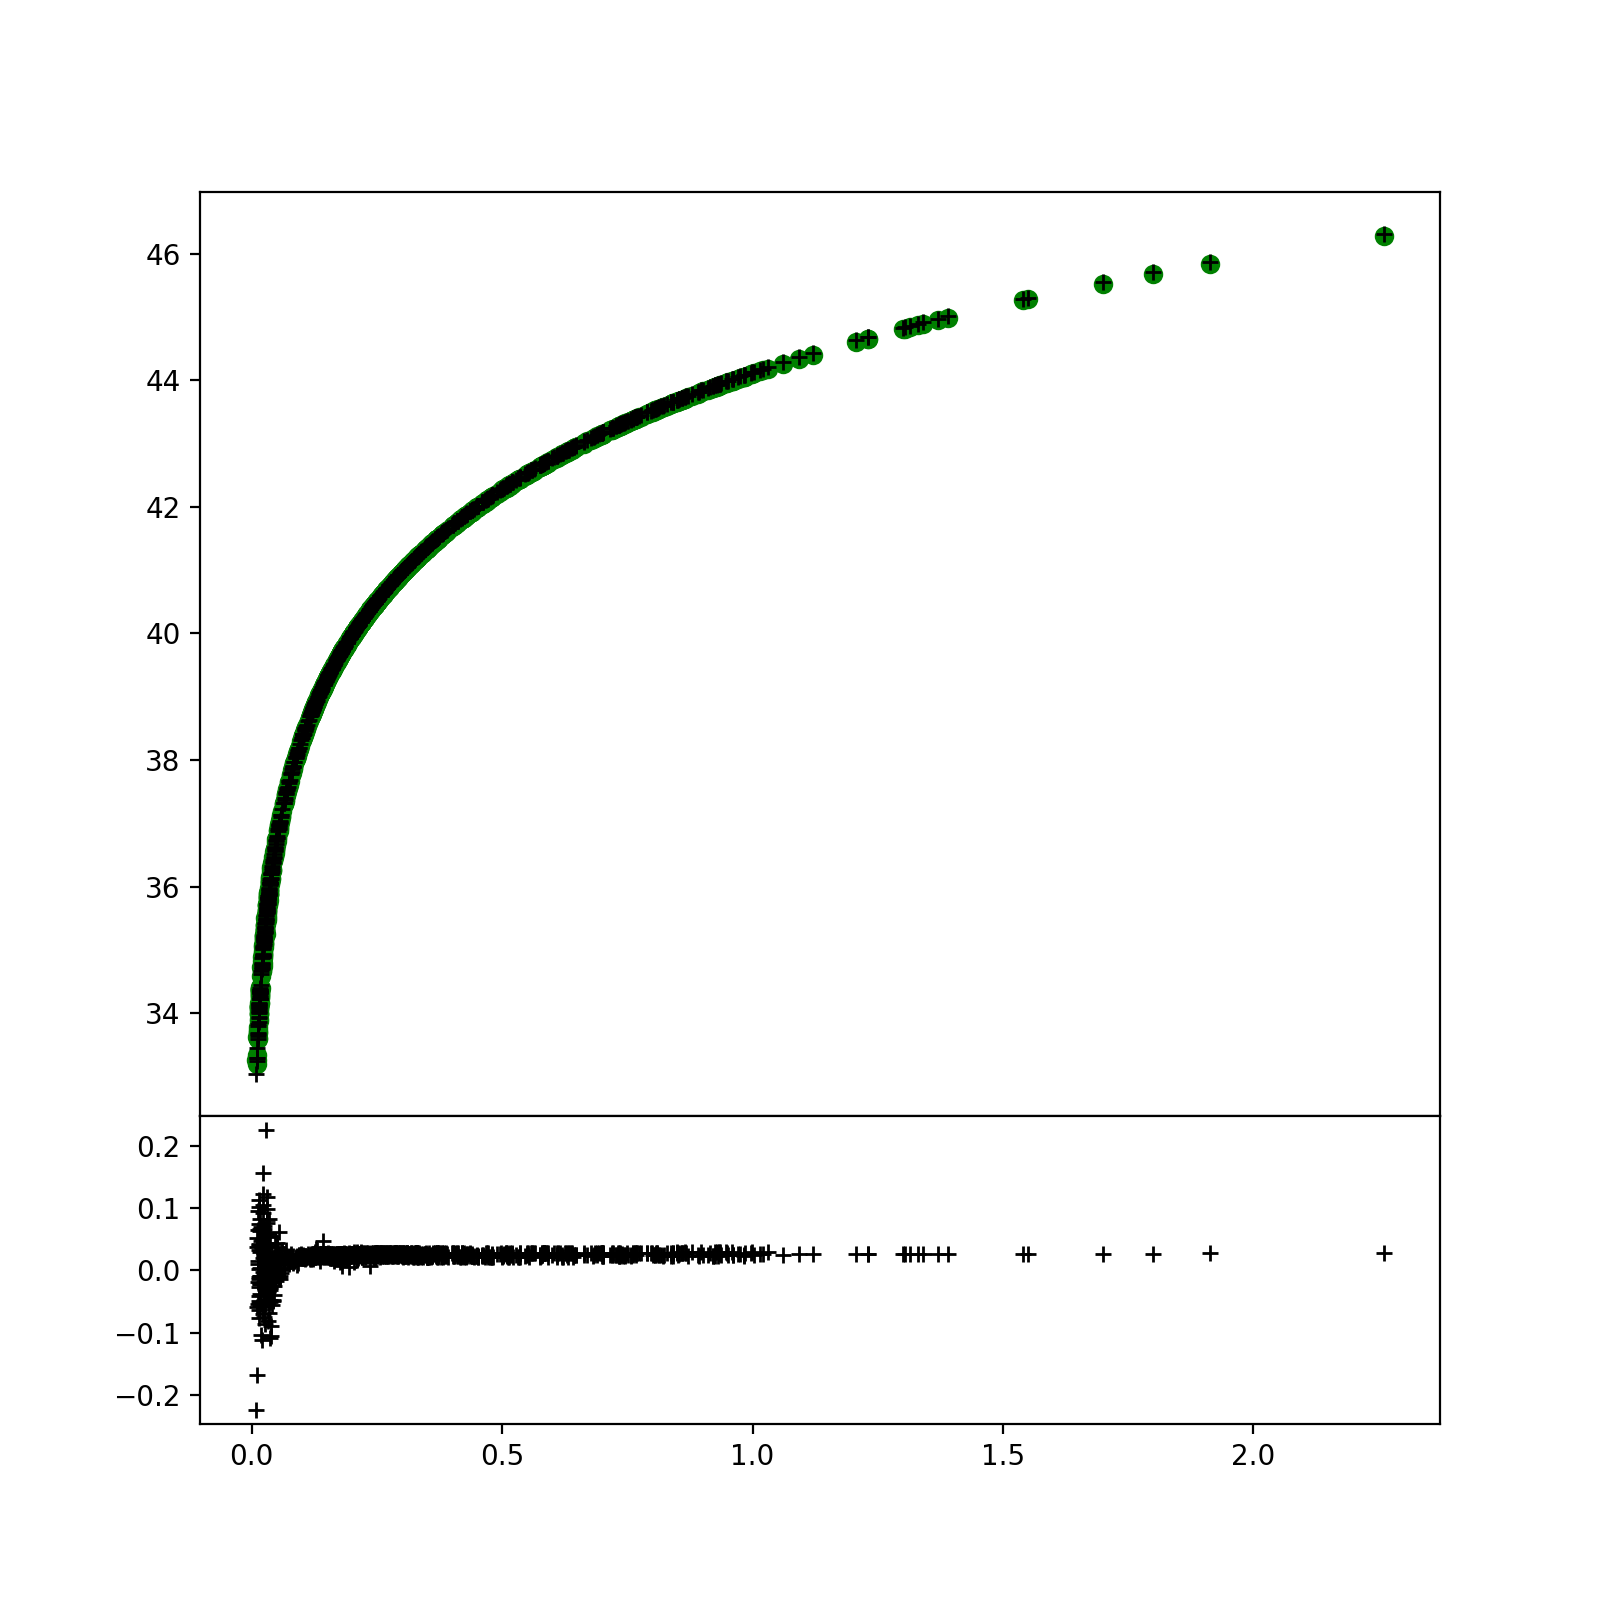

In [29]:

filename_G10 = '../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-g10.fitres'
filename_C11 = '../data/hlsp_ps1cosmo_panstarrs_gpc1_all_model_v1_ancillary-c11.fitres'
SNdata_G10 = pandas.read_csv(filename_G10, comment='#', skiprows=6, header=0, delimiter=r"\s+")
SNdata_C11 = pandas.read_csv(filename_C11, comment='#', skiprows=6, header=0, delimiter=r"\s+")

zcmb = SNdata_G10['zCMB']
zhel = SNdata_G10['zHD']
mu = SNdata_G10['MUMODEL']
dataset = SNdata_G10['IDSAMPLE']

# Theoretical curve (LambdaCDM)
# xfunc = np.linspace(0.001, 2, 1000)
# yfunc = np.zeros(len(xfunc))
yfunc = fitfundL(zcmb, 0.298, 0.00006924)

fig = plt.figure(figsize=[8,8])
P1, P2 = fig.subplots(2, 1, sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[3,1]))
fig.subplots_adjust(hspace=0)

P1.plot(zcmb, SNdata_G10['MUMODEL'], color="green", marker='o', linestyle="None", label='Pantheon data')

# P1.errorbar(zcmb, mu_exp, yerr=dmu_exp, marker='.', color="blue", linestyle="None", ecolor="blue", label='Pantheon data')
# P1.plot(xfunc, yfunc, c="red", label="$\Lambda$CDM fit")
# P1.set_xlabel('Redshift z')
# P1.set_ylabel(r'Distance modulus $\mu = m_B - M_B + \alpha x_1 - \beta c + \Delta_M$')  
# #P1.set_xscale('log')
# P1.set_xlim(0., 2.3)
# P1.set_ylim(30, 48)
# P1.text(0.2, 31, str_fit, fontsize=12)
# P1.legend(loc='best', shadow=True, fontsize='x-large')
# P2.errorbar(zcmb, mu_res, yerr=dmu_res, marker='.', color="blue", linestyle="None", ecolor="blue")

P1.plot(zcmb, yfunc, marker='+', color="black", linestyle="None")


P2.plot(zcmb, yfunc-SNdata_G10['MUMODEL'], marker='+', color="black", linestyle="None")

